In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
from PIL import Image
from numpy import asarray

np.set_printoptions(precision=5)#show 5 number after decimal point 

In [40]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [41]:
url = r"train\\"

In [42]:
def create_data():
    data = list()
    label = 0 #cat = 1 , dog = 0
    for img in tqdm(os.listdir(url)):
        if img.startswith('cat'): label = 1 
        else :label = 0 
        im = asarray(Image.open(url+img).resize((40,40)).convert('L')) #resize and changing colors
        data.append([im,label])
    np.save('data.npy', data)
    return data

In [13]:
data = create_data()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:36<00:00, 90.52it/s]


In [43]:
# load the data:
data = np.load('data.npy',allow_pickle=True)

In [44]:
X = (np.array([i[0] for i in data]))
Y = (np.array([i[1] for i in data]))

In [45]:
X = X /255.0

In [46]:
X.shape

(25000, 40, 40)

Text(0.5, 1.0, 'DOG')

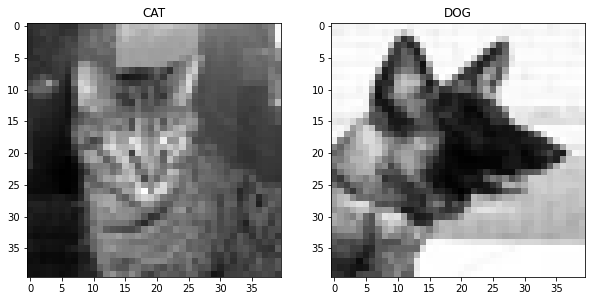

In [47]:
fig = plt.figure(figsize=(10, 7))
  
fig.add_subplot(1, 2, 1)
plt.imshow(X[1,:], cmap=plt.get_cmap('gray'))
plt.title("CAT")

fig.add_subplot(1, 2, 2)
plt.imshow(X[24999,:], cmap=plt.get_cmap('gray'))
plt.title("DOG")

In [48]:
X = X.reshape((25000, 40*40))
X.shape

(25000, 1600)

In [49]:
#split the data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [50]:
#split the train
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [51]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_val)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val),3))

The DummyClassifier score is: 0.503


## *Models :*


### Feature selection: 

In [60]:
scores = [] 
num_fetures = [] 
for i in range(150,1300,150):
    X_new = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new,y_train, test_size=0.1, random_state=42)
    XGB = XGBClassifier(objective="binary:logistic", random_state=42)
    XGB.fit(X_train_new, y_train_new, eval_metric='auc')
    y_predict = XGB.predict(X_val_new)
    accuracy = (round(metrics.accuracy_score(y_val_new, y_predict),3))
    #print("number of features : ", i, ", Accuracy:", accuracy)
    scores.append(accuracy)
    num_fetures.append(i)

KeyboardInterrupt: 

In [ ]:
plt.plot(num_fetures, scores)

>The best score of the model was with 1250 feature - We will use this number of features for other models as well.

In [36]:
X_train = SelectKBest(chi2, k=1250).fit_transform(X_train, y_train)

ValueError: k should be >=0, <= n_features = 1225; got 1250. Use k='all' to return all features.

In [38]:
X_val = SelectKBest(chi2,k=1250).fit_transform(X_val,y_val)

ValueError: k should be >=0, <= n_features = 1225; got 1250. Use k='all' to return all features.

In [30]:
X_train.shape

(20250, 1225)

In [31]:
X_val.shape

(2250, 1225)

### *Random Forest Classifier :*

In [18]:
%%time

RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_val)
accuracy = round(metrics.accuracy_score(y_val,y_pred_RF),3)
print("Accuracy:", accuracy)

Accuracy: 0.558
CPU times: total: 59.7 s
Wall time: 1min


In [90]:
%%time

kf= KFold(n_splits=5, random_state=42, shuffle=True)
RForest = RandomForestClassifier(random_state=42)
random_forest= cross_val_score(RForest, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(round(random_forest,3))

0.638
CPU times: total: 3min 19s
Wall time: 3min 21s


### *XGB Classifier:*

In [76]:
%%time

XGBoost = XGBClassifier(objective="binary:logistic", random_state=42)
XGBoost.fit(X_train, y_train, eval_metric='auc')
y_pred_XGB = XGBoost.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred_XGB),3)
print("Accuracy:", accuracy)

Accuracy: 0.669
CPU times: total: 20min 15s
Wall time: 3min 1s


[8.62666e-05 0.00000e+00 2.21149e-04 ... 4.92497e-04 5.31248e-04
 1.47759e-03]


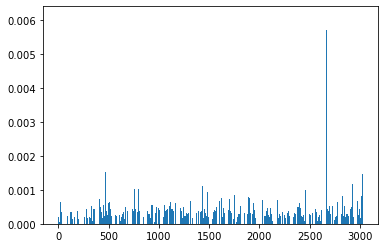

In [77]:
print(XGBoost.feature_importances_)
# plot
pyplot.bar(range(len(XGBoost.feature_importances_)), XGBoost.feature_importances_)
pyplot.show()

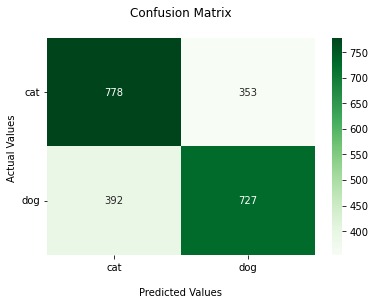

In [79]:

cf_matrix = confusion_matrix(y_val, y_pred_XGB)
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["cat","dog"])
ax.yaxis.set_ticklabels(["cat","dog"],rotation=0)

plt.show()

In [80]:
%%time

kf= KFold(n_splits=5, random_state=42, shuffle=True)
XGBClassifier = XGBClassifier(objective="binary:logistic", random_state=42,eval_metric='auc')
XGB = cross_val_score(XGBClassifier, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(round(XGB,3))

0.6555061728395062
CPU times: total: 1h 29min 56s
Wall time: 13min 8s


### *AdaBoost Classifier:*

In [81]:
%%time

AdB = AdaBoostClassifier()
AdB.fit(X_train, y_train)
y_pred = AdB.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.601
CPU times: total: 6min 24s
Wall time: 6min 24s


In [82]:
%%time

kf= KFold(n_splits=3, random_state=42, shuffle=True)
AdaBoost = AdaBoostClassifier()
AdB = cross_val_score(AdaBoost, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(AdB)


0.5813827160493826
CPU times: total: 9min 17s
Wall time: 9min 19s


### *Gradient Boosting Classifier:*

In [83]:
GBC = GradientBoostingClassifier(verbose=1).fit(X_train, y_train)
y_pred = GBC.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))    

      Iter       Train Loss   Remaining Time 
         1           1.3795           25.98m
         2           1.3731           25.17m
         3           1.3676           24.98m
         4           1.3624           24.75m
         5           1.3575           24.57m
         6           1.3532           24.39m
         7           1.3484           24.00m
         8           1.3444           23.72m
         9           1.3397           23.50m
        10           1.3365           23.26m
        20           1.3048           20.69m
        30           1.2798           17.98m
        40           1.2608           15.31m
        50           1.2447           12.70m
        60           1.2292           10.18m
        70           1.2160            7.64m
        80           1.2028            5.08m
        90           1.1910            2.55m
       100           1.1777            0.00s
Accuracy: 0.653


### *PCA:*

Text(0, 0.5, 'cumulative explained variance')

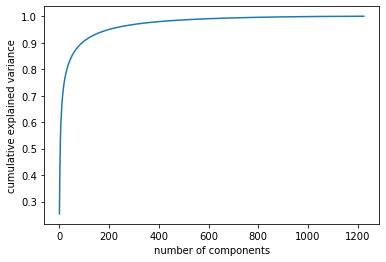

In [32]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [33]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_reduced_train = pca.transform(X_train)
X_reduced_test = pca.transform(X_val)

In [34]:
X_reduced_train.shape

(20250, 201)

Text(0.5, 1.0, 'After PCA')

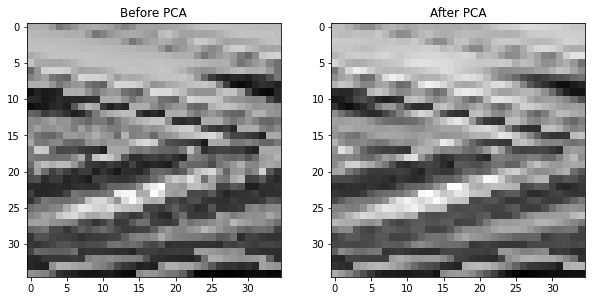

In [35]:
fig = plt.figure(figsize=(10, 7))
X_recovered = pca.inverse_transform(X_reduced_train)
  
fig.add_subplot(1, 2, 1)
plt.imshow(X_train[2,:].reshape(35,35), cmap=plt.get_cmap('gray'))
plt.title("Before PCA")

fig.add_subplot(1, 2, 2)
plt.imshow(X_recovered[2,:].reshape(35,35), cmap=plt.get_cmap('gray'))
plt.title("After PCA")

In [30]:
y_train.shape

(20250,)

In [31]:
%%time
XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_reduced_train, y_train,eval_metric='auc')

CPU times: total: 3min 31s
Wall time: 31.4 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
y_pred = XGB.predict(X_reduced_test)      
accuracy = metrics.accuracy_score(y_val, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.636


### Hyperparameter Tuning: 

In [84]:
#Searching for better performance out of the models with RandomizedSearch

In [70]:
#XGBClassifier
parameters = {
        'max_depth': [3,4,5,6],
        'n_estimators' : [100,150,170,190,200]
         }

random_XGB = RandomizedSearchCV(XGBClassifier(),parameters, verbose=True, 
                          cv=4,random_state=42, return_train_score=True)
random_XGB.fit(X_reduced_train,y_train, eval_metric='auc')
y_pred_XGB_random = random_XGB.predict(X_reduced_test)
print ("Accuracy Score = ",round(metrics.accuracy_score(y_val,y_pred_XGB_random),3))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Accuracy Score =  0.636


In [71]:
random_XGB.best_params_

{'n_estimators': 190, 'max_depth': 3}

### *VotingClassifier :*

In [33]:
lgb = lgb.LGBMClassifier()
dt_clf = DecisionTreeClassifier()
log_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
rnd_clf = RandomForestClassifier()
XGBClassifier = XGBClassifier(objective= 'binary:logistic',eval_metric='auc')

voting_clf = VotingClassifier(estimators=[('lgb', lgb),('XGB', XGBClassifier),('rnd',rnd_clf),('dt',dt_clf)
                                          ,('lr', log_clf), ('knn', knn_clf)
                                          ],voting='hard',n_jobs=-1,)
voting_clf.fit(X_reduced_train, y_train)

VotingClassifier(estimators=[('lgb', LGBMClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric='auc', gamma=None,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child...
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None)),
                             ('rnd', RandomForestClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('lr', LogisticRegression()),
                             ('knn', KNeighborsClassifier())],
                 n_jobs=-1)

In [34]:
for clf in (lgb,XGBClassifier, rnd_clf, dt_clf, log_clf, knn_clf, voting_clf):
    clf.fit(X_reduced_train, y_train)
    y_pred = clf.predict(X_reduced_test)
    print(clf.__class__.__name__, round(accuracy_score(y_val, y_pred),3))

LGBMClassifier 0.647
XGBClassifier 0.636
RandomForestClassifier 0.606
DecisionTreeClassifier 0.549
LogisticRegression 0.567
KNeighborsClassifier 0.6
VotingClassifier 0.651


### *KMeans :*

In [74]:
pipeline = Pipeline([
 ("kmeans", KMeans(n_clusters=10)),
 ("lgb", lgb.LGBMClassifier())])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=10)), ('lgb', LGBMClassifier())])

In [75]:
y_pred_pipe = pipeline.predict(X_val)

In [76]:
round(metrics.accuracy_score(y_val,y_pred_pipe),3)

0.593

### testing the final models
- XGB
- XGB with PCA 

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [78]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_reduced_train = pca.transform(X_train)
X_reduced_test = pca.transform(X_test)

In [80]:
%%time
XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_reduced_train, y_train,eval_metric='auc')

CPU times: total: 5min 39s
Wall time: 52.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
y_pred = XGB.predict(X_reduced_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

Accuracy: 0.627


In [82]:
%%time
XGBoost = XGBClassifier(objective="binary:logistic", random_state=42)
XGBoost.fit(X_train, y_train, eval_metric='auc')
y_pred_XGB = XGBoost.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred_XGB),3)
print("Accuracy:", accuracy)

Accuracy: 0.658
CPU times: total: 11min 11s
Wall time: 1min 46s


## *The best model accuracy : 0.676*